In [149]:
import pandas_datareader
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split

df_price = pandas_datareader.DataReader(
    "^KS11", "yahoo", datetime.datetime(2018, 2, 20), datetime.datetime(2021, 3, 13)
)

scaler = MinMaxScaler()
scale_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df_price[scale_columns])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_columns
# print(df_scaled)

In [150]:
TEST_SIZE = 60

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

# make_dataset funtion은 window_size만큼의 길이를 가진 데이터로 편집 eg. window_size가 2라면
# [
#     [[0일차][1일차]]
#     [[1일차][2일차]]
#     [[...][...]]
# ]
# 꼴로 만들어준다.

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


In [151]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

# 최근 200일은 test data 그거 뺀 나머지는 train data
train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]


# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
# train과 validation set을 나누는 건 Overfitting을 방지하기 위한 수단이다.
# https://teddylee777.github.io/scikit-learn/train-test-split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
 
print(train_feature.shape, x_train.shape, x_valid.shape)
# x_train은 총 data에서 0.8만큼의 train할 데이터 x_valid는 총 data에서 validation 할 0.2 만큼의 data로 잘린걸 알 수 있다. 28->22, 6으로 나뉨 20,4는 windowsize와 featurecols로 일정하다. x,y는 각각 train_feature train_label

# 실제 예측 해 볼 데이터 testdata (최근 200일)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
print(test_feature.shape, test_label.shape)


(670, 20, 4) (536, 20, 4) (134, 20, 4)
(40, 20, 4) (40, 1)


In [152]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [153]:
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.99, nesterov=True)

In [154]:
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer=sgd)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_path = 'C:/98_Git/Porsche_Buying_Project/PBP/Temp/'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

mprove from 0.00040
Epoch 18/200
34/34 [==============================] - 0s 6ms/step - loss: 4.5595e-04 - val_loss: 4.1616e-04

Epoch 00018: val_loss did not improve from 0.00040
Epoch 19/200
34/34 [==============================] - 0s 6ms/step - loss: 3.6746e-04 - val_loss: 4.2435e-04

Epoch 00019: val_loss did not improve from 0.00040
Epoch 20/200
34/34 [==============================] - 0s 6ms/step - loss: 5.0001e-04 - val_loss: 4.3281e-04

Epoch 00020: val_loss did not improve from 0.00040
Epoch 21/200
34/34 [==============================] - 0s 6ms/step - loss: 5.5126e-04 - val_loss: 3.9540e-04

Epoch 00021: val_loss improved from 0.00040 to 0.00040, saving model to C:/98_Git/Porsche_Buying_Project/PBP/Temp\tmp_checkpoint.h5
Epoch 22/200
34/34 [==============================] - 0s 6ms/step - loss: 4.9256e-04 - val_loss: 3.8369e-04

Epoch 00022: val_loss improved from 0.00040 to 0.00038, saving model to C:/98_Git/Porsche_Buying_Project/PBP/Temp\tmp_checkpoint.h5
Epoch 23/200
34/34

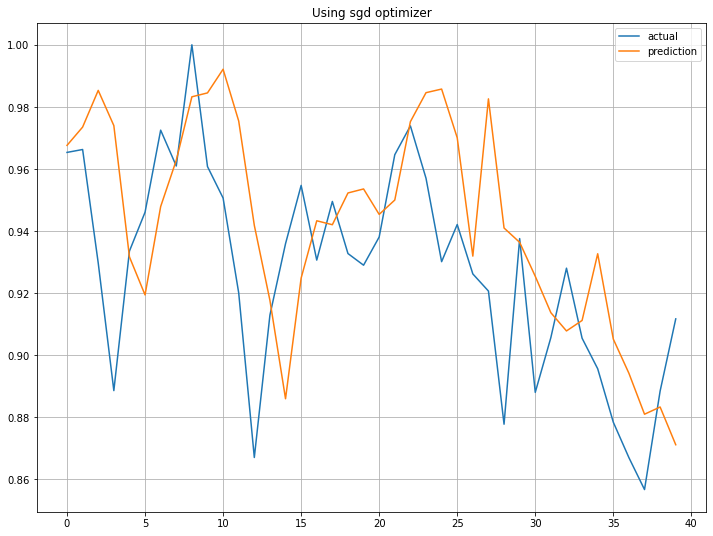

In [156]:
import matplotlib.pyplot as plt

model.load_weights(filename)
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.grid(True)
plt.plot(test_label, label="actual")
plt.plot(pred, label="prediction")
plt.legend()
plt.title('Using sgd optimizer')
plt.show()
